# WINE QUALITY PREDICTION

## 1. Memanggil *Library* Yang Dibutuhkan

In [24]:
# Library Pengolahan Data
import pandas as pd
import numpy as np
from collections import Counter
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Library Visualisasi Data
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk Pemodelan
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


## 2. Mempersiapkan *Dataset*

### 2.1 Mengunduh Dataset Dari Kaggle

In [2]:
# Melakukan Pengaturan API Kaggle 
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Mengambil Dataset Dari Kaggle
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009

  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 9.87MB/s]


### 2.2 Memuat Dataset

In [4]:
# Ekstrasi Dataset
path = '/content/red-wine-quality-cortez-et-al-2009.zip'
with ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('working')

In [5]:
# Memuat Dataset Dengan Library Pandas
wines = pd.read_csv('/content/working/winequality-red.csv')

## 3. Pemahaman Data

In [6]:
# Melihat Isi Dataset
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Berikut adalah penjelasan dari variabel-variabel pada dataset Wine :
* **fixed acidity** : kandungan asam yang bersifat fixed
* **volatile acidity** : kandungan asam yang bersifat volatile
* **citric acid** : kandungan asam sitrat
* **residual sugar** : jumlah kandungan gula residual setelah hasil fermentasi 
* **chlorides** : kandungan garam pada wines
* **free sulfur dioxide** : kandungan SO2 dalam bentuk kesetimbangan antara molekul SO2 (sebagai gas terlarut) dan ion bisulfit
* **total sulfur dioxide** : jumlah keseluruhan S02
* **density** : tingkat density cairan
* **pH** : menggambarkan seberapa asam atau basa anggur dalam skala dari 0 (sangat asam) hingga 14 (sangat basa)
* **sulphates** : kadar aditif wines yang dapat berkontribusi pada tingkat gas sulfur dioksida (S02)
* **alcohol** : persentase kandungan alkohol pada wines
* **quality** : variabel output berdasarkan data sensorik dengan skor dari 0 sampai 10

## 4. Eksplorasi Data

### 4.1 EDA - Deskripsi Variabel

In [7]:
# Melihat Informasi Dataset
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [8]:
# Melihat deskripksi tiap kolom
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### 4.2 EDA - Missing values dan Outliers

In [9]:
# Melakukan cek data kosong
wines.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

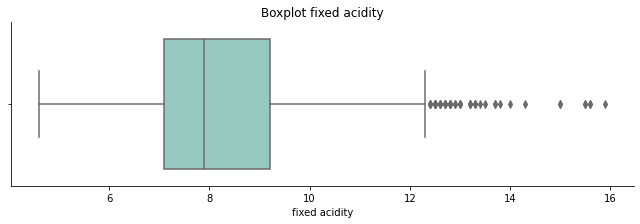

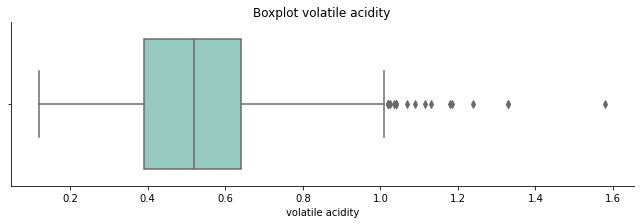

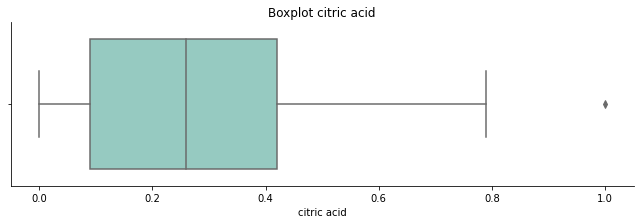

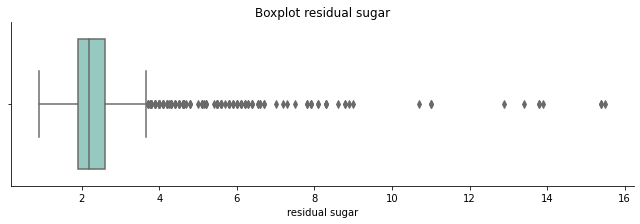

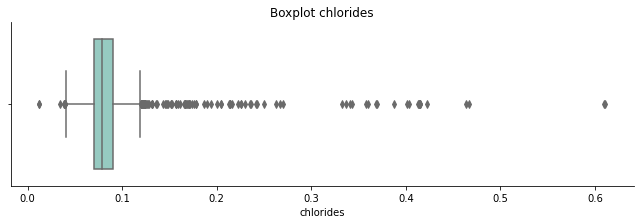

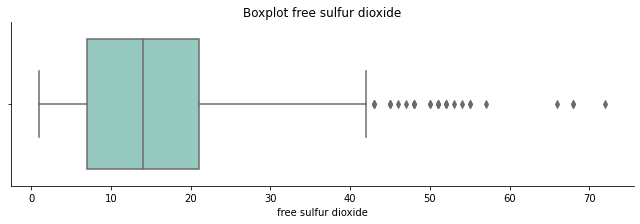

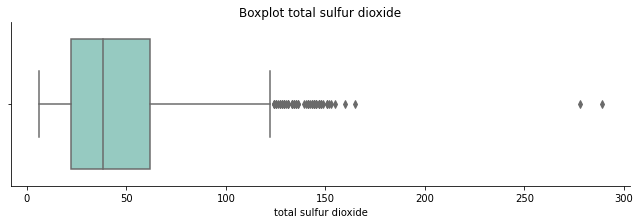

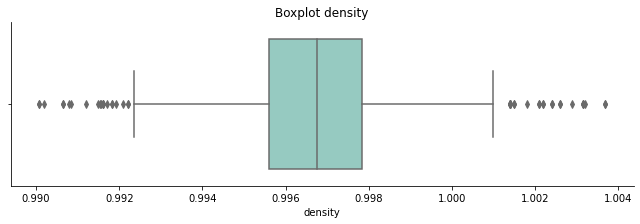

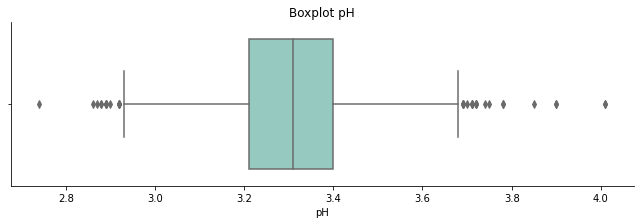

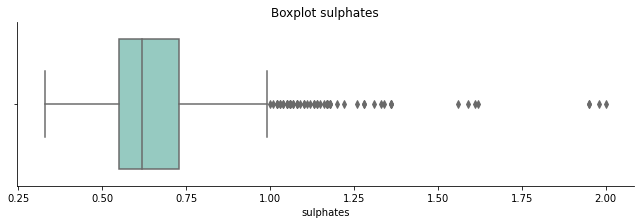

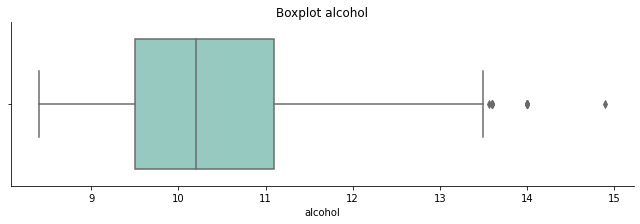

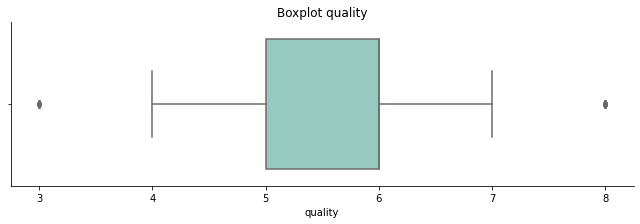

In [10]:
# Mengidentifikasi ouliers
cols = [col for col in wines.columns]
for col in cols:
  sns.catplot(x=col, kind='box', data=wines, aspect=3, height=3, palette = 'Set3')
  plt.title(f'Boxplot {col}')

In [11]:
# Membuat Fungsi Untuk Mendeteksi Baris yang memiliki lebih dari 2 outliers pada kolomnya
def detect_outliers(df, features):
  outlier_indices = []

  for f in features:
    # Quartile Pertama
    Q1 = df[f].quantile(0.25)
    # Quartile Kedua
    Q3 = df[f].quantile(0.75)
    # Interquartile Range
    IQR = Q3 - Q1
    # Deteksi outlier beserta index barisnya 
    outlier_list_col = df[((df[f] < Q1 - 1.5 * IQR)|(df[f] > Q3 + 1.5 * IQR))].index
    # Menambahkannya kedalam list
    outlier_indices.extend(outlier_list_col)

  # Menghitung jumlah outlier untuk tiap index
  outlier_indices=Counter(outlier_indices)    
  # Memilih index yang memiliki outlier lebih dari 2
  multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
  return multiple_outliers

In [12]:
# Melihat Jumlah baris yang memiliki outlier lebih dari 2
print(f"Total baris yang memiliki outliers bernilai > 2 : {len(detect_outliers(wines,cols))} ")
# Cek lokasi
wines.loc[detect_outliers(wines,cols)]

Total baris yang memiliki outliers bernilai > 2 : 37 


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
353,13.5,0.530,0.79,4.80,0.120,23.0,77.0,1.00180,3.18,0.77,13.0,5
364,12.8,0.615,0.66,5.80,0.083,7.0,42.0,1.00220,3.07,0.73,10.0,7
366,12.8,0.615,0.66,5.80,0.083,7.0,42.0,1.00220,3.07,0.73,10.0,7
374,14.0,0.410,0.63,3.80,0.089,6.0,47.0,1.00140,3.01,0.81,10.8,6
440,12.6,0.310,0.72,2.20,0.072,6.0,29.0,0.99870,2.88,0.82,9.8,8
442,15.6,0.685,0.76,3.70,0.100,6.0,43.0,1.00320,2.95,0.68,11.2,7
538,12.9,0.350,0.49,5.80,0.066,5.0,35.0,1.00140,3.20,0.66,12.0,7
554,15.5,0.645,0.49,4.20,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
555,15.5,0.645,0.49,4.20,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
557,15.6,0.645,0.49,4.20,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5


In [13]:
# Melakukan drop outlier
wines = wines.drop(detect_outliers(wines,cols),axis = 0).reset_index(drop = True)
wines.shape

(1562, 12)

### 4.3 EDA - Univariate Analysis

Text(0.5, 1.0, 'Persebaran Data Quality')

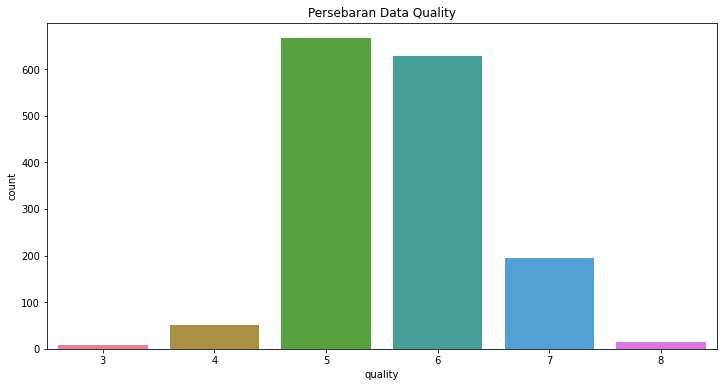

In [14]:
# Melihat Distribusi Quality
plt.figure(figsize=(12, 6))
sns.countplot(x="quality", data=wines, palette='husl');
plt.title('Persebaran Data Quality')

Berdasarkan grafik persebaran data quality, kita dapatkan bahwa persebarannya paling banyak pada quality 5 dan 6. Nantinya nilai quality akan dikelompokkan menjadi 2 kelas, yaitu good (1) untuk quality > 6.5 and not good (0) untuk quality < 6.5.

### 4.4 EDA - Multivariate Analysis

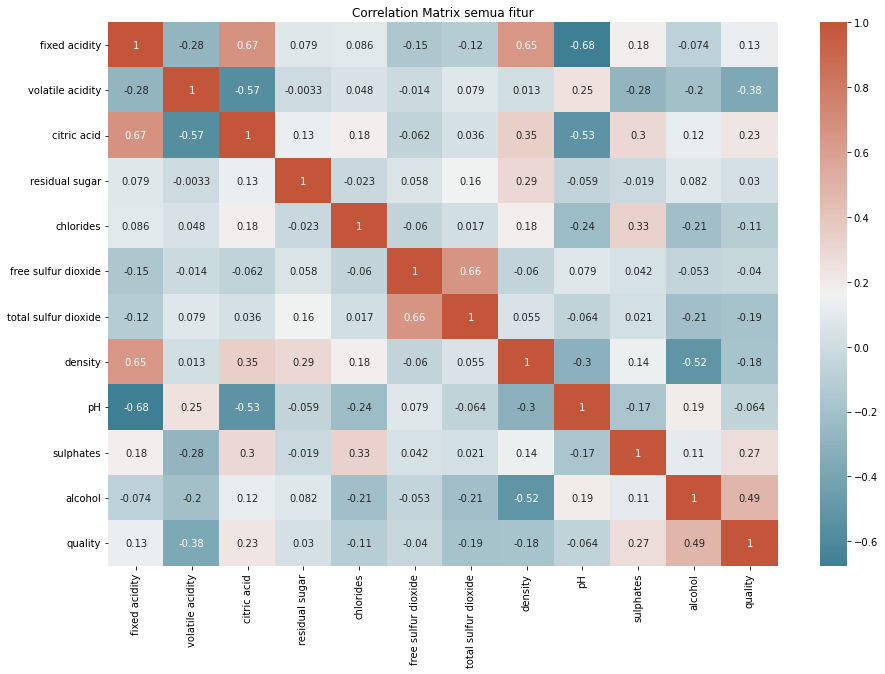

In [15]:
corr = wines.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title("Correlation Matrix semua fitur")
plt.show()

Berdasarkan correaltion matrik diatas, fitur yang memiliki korelasi diantara -0.1 sampai 0.1 dengan fitur quality adalah **residual sugar, free sulfur dioxide,** dan **pH**. Oleh karena itu fitu tersebut nantinya dapat di drop

## 5. Pengolahan Data

### 5.1 Mempersiapkan Data Untuk Klasifikasi

Text(0.5, 1.0, 'Proporsi Good Quality')

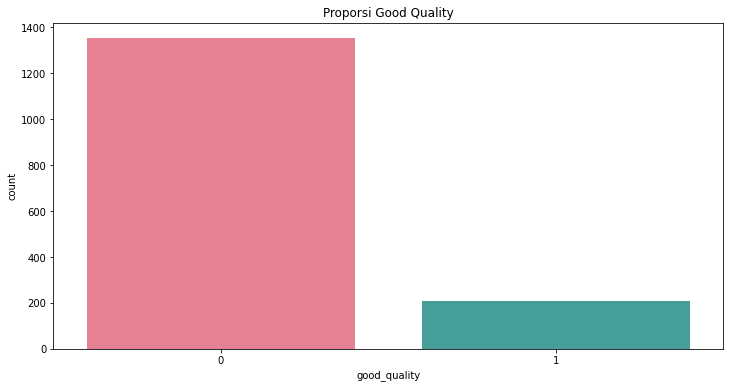

In [16]:
# Membuat fitur klasifikasi good dan not good pada fitur quality
wines['good_quality'] = [1 if n > 6.5 else 0 for n in wines['quality']]
# Melihat proporsi klasifikasi
plt.figure(figsize=(12, 6))
sns.countplot(x="good_quality", data=wines, palette='husl');
plt.title('Proporsi Good Quality')

In [18]:
# Memisahkan fitur dan target
X = wines.drop(['quality', 'good_quality', 'residual sugar', 'free sulfur dioxide', 'pH'], axis = 1)
y = wines['good_quality']

In [19]:
# Membagi train dan test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 610)

### 5.2 Standarisasi

In [20]:
# Standarisasi Fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 6. Pemodelan

In [21]:
# Pelatihan model
rf = RandomForestClassifier(max_depth = 7, n_estimators = 30)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 7. Evaluasi Model

In [22]:
# Pengujian Model Terhadap Train dan Test Dataset
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(f"Hasil Akurasi Train : {accuracy_score(y_train, y_pred_train)}")
print(f"Hasil Akurasi Test : {accuracy_score(y_test, y_pred_test)}")


Hasil Akurasi Train : 0.9575660528422738
Hasil Akurasi Test : 0.8913738019169329


## 8. Tuning Model

In [26]:
# Hyper parameter yang akan dituning
params_rf = {'n_estimators':[10,30,50,70,90],
            'max_depth':[3,5,7,9,11,13],
            'max_features':['log2','sqrt']}

# Pencarian parameter terabaik dengan Grid Search CV
rf = RandomForestClassifier()
grid_rf = GridSearchCV(estimator = rf,
                      param_grid = params_rf,
                      cv=3,
                      scoring = 'accuracy',
                      verbose = 1,
                      n_jobs = -1)
grid_rf.fit(X_train, y_train)
y_pred = grid_rf.predict(X_test)

# Hasil tuning hyperparameter dengan skor terbaik yang didapatkan
print(f"Best Parameter : {grid_rf.best_params_}")
print(f"Best Score : {grid_rf.best_score_}")

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.1s


Best Parameter : {'max_depth': 13, 'max_features': 'sqrt', 'n_estimators': 50}
Best Score : 0.9159384031236549


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   15.3s finished


In [29]:
# Hasil klasifikasi tuning model
report = classification_report(y_pred,y_test,output_dict=True, target_names=['Not Good','Good'])
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
Not Good,0.974074,0.922807,0.947748,285.000000
Good,0.488372,0.750000,0.591549,28.000000
accuracy,0.907348,0.907348,0.907348,0.907348
macro avg,0.731223,0.836404,0.769649,313.000000
weighted avg,0.930625,0.907348,0.915883,313.000000


In [30]:
# Menerapkan hyperparameter hasil tuning
rf = RandomForestClassifier(max_depth = 13, n_estimators = 10, max_features='sqrt')
rf.fit(X_train, y_train)
# Pengujian Model Terhadap Train dan Test Dataset
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(f"Hasil Akurasi Train : {accuracy_score(y_train, y_pred_train)}")
print(f"Hasil Akurasi Test : {accuracy_score(y_test, y_pred_test)}")

Hasil Akurasi Train : 0.9911929543634908
Hasil Akurasi Test : 0.9073482428115016


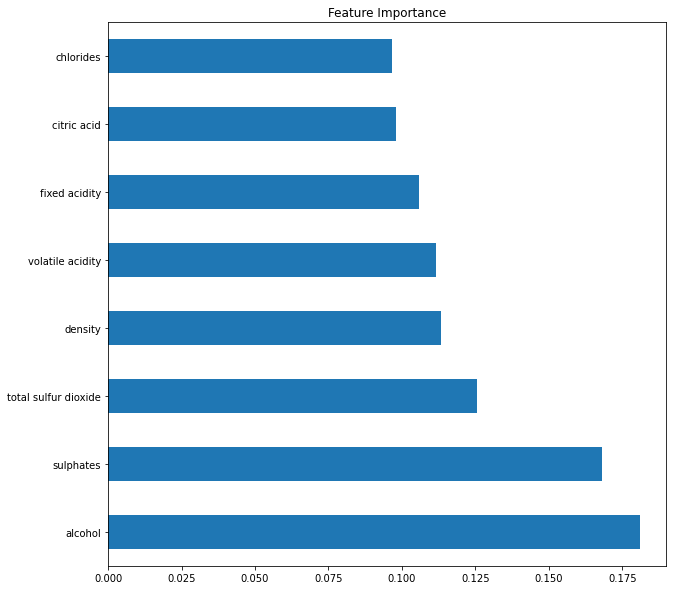

In [38]:
# Melihat fitur yang paling berpengaruh
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))
plt.title("Feature Importance")
plt.show()

In [41]:
# Filtering wines hanya untuk good quality
wines_temp = wines[wines['good_quality']==1]
display(wines_temp.describe())
# Filtering wines hanya untuk not good quality
wines_temp2 = wines[wines['good_quality']==0]
display(wines_temp2.describe())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good_quality
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.0
mean,8.792823,0.402368,0.373876,2.672727,0.076158,14.066986,34.454545,0.995966,3.289809,0.743589,11.504386,7.071770,1.0
std,1.853296,0.144637,0.189198,1.332678,0.028785,10.306029,32.957564,0.001981,0.144794,0.136184,0.952703,0.258727,0.0
min,5.100000,0.120000,0.000000,1.200000,0.012000,3.000000,7.000000,0.990640,2.920000,0.390000,9.200000,7.000000,1.0
25%,7.400000,0.300000,0.310000,2.000000,0.062000,6.000000,16.000000,0.994700,3.200000,0.650000,10.800000,7.000000,1.0
50%,8.700000,0.360000,0.400000,2.300000,0.073000,11.000000,25.000000,0.995720,3.280000,0.740000,11.600000,7.000000,1.0
75%,10.100000,0.480000,0.490000,2.700000,0.086000,18.000000,43.000000,0.997300,3.370000,0.830000,12.200000,7.000000,1.0
max,15.000000,0.915000,0.760000,8.900000,0.358000,54.000000,289.000000,1.000400,3.780000,1.360000,13.600000,8.000000,1.0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good_quality
count,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.0
mean,8.204878,0.545477,0.252069,2.434220,0.087919,15.827051,47.580931,0.996810,3.316430,0.641293,10.241784,5.413156,0.0
std,1.614044,0.174172,0.187293,1.179296,0.045789,9.787537,31.950763,0.001713,0.150372,0.164302,0.945074,0.595872,0.0
min,4.600000,0.160000,0.000000,0.900000,0.038000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000,3.000000,0.0
25%,7.100000,0.420000,0.080000,1.900000,0.071000,8.000000,23.000000,0.995770,3.210000,0.540000,9.500000,5.000000,0.0
50%,7.800000,0.540000,0.240000,2.200000,0.080000,14.000000,39.000000,0.996800,3.320000,0.600000,10.000000,5.000000,0.0
75%,9.000000,0.650000,0.400000,2.600000,0.090000,22.000000,64.000000,0.997860,3.410000,0.700000,10.900000,6.000000,0.0
max,14.300000,1.330000,0.780000,15.500000,0.611000,57.000000,165.000000,1.002890,4.010000,1.980000,14.000000,6.000000,0.0


## Kesimpulan

Dengan melihat detail dari good quality dan not good quality, kita dapat melihat bahwa wines dengan kualitas baik memiliki kadar alkohol rata-rata lebih tinggi, rata-rata memiliki keasaman volatil yang lebih rendah, kadar sulfat rata-rata yang lebih tinggi, dan kadar gula residual rata-rata yang lebih tinggi.

### Referensi
* P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.
* https://www.kaggle.com/namanmanchanda/red-wine-eda-and-classification
* https://www.kaggle.com/tommorowsengineer/wine-quality-classification-100-accuracy-with-knn